# Face mask recognition using the Dlib convolutional neural network for face recognition and Google's inception for facemask recognition

### Sabrina Stoeckli and Alfonso Rojas Mora



During the current pandemic, the use of face masks has become one important mechanism to reduce the transmission of SARS-COV2. However, people is yet reluctant to use masks in public, and thus we decided to create a machine learning model able to detect whether people is wearing their masks.

The data used here is freely available in Kaggle. A total of 1006 photos were used to train and validate the inception model, where half of the photos were of people wearing a mask while the other half of people without a face mask. The inception model used for this task is just a small model containing a few layers.


## The objective

Ideally, if we have a photo with various people, we would like to mark who is wearing or not a mask, thus our expected outcome would be like:
<img src="./Expected_outcome.png" alt="Drawing" style="width: 330px;" align="left"/>



## Prepare all the libraries and define all the functions needed for the project

In [ ]:
import numpy as np
import pandas as pd
import os
import dlib
import cv2
import matplotlib.pyplot as plt
from imutils import face_utils
import tensorflow as tf
from keras import Sequential
from keras.layers import Flatten, Dense
import PIL.Image
from utils import gr_disp
from utils import inception
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
def show_graph(g=None, gd=None):
    gr_disp.show_graph_eager(g, gd)
    %tensorboard --logdir logs
%load_ext tensorboard

In [2]:
# Function use to load the graph of the inception model
def load_graph_def(file_path, use_GPU=False):
    with tf.compat.v1.gfile.GFile(file_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def_str = f.read()
        if use_GPU:
            graph_def_str = graph_def_str.replace(b'/cpu:0', b'/gpu:0')
        graph_def.ParseFromString(graph_def_str)
    return graph_def

gd = load_graph_def('inception/tensorflow_inception_graph.pb')

# Function use to build the model and save the built model
def convert_model(file_path, save_path, io_tensors, use_GPU=False):
    builder = tf.compat.v1.saved_model.builder.SavedModelBuilder(save_path)
  
    graph_def = load_graph_def(file_path, use_GPU)
  
    sigs = {}
  
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        # name="" is important to ensure we don't get spurious prefixing
        tf.compat.v1.import_graph_def(graph_def, name="")
        g = tf.compat.v1.get_default_graph()
        inp = g.get_tensor_by_name(io_tensors[0])
        out = g.get_tensor_by_name(io_tensors[1])
  
        sigs[signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY] = \
            tf.compat.v1.saved_model.signature_def_utils.predict_signature_def(
                {"in": inp}, {"out": out})
  
        builder.add_meta_graph_and_variables(sess,
                                            [tag_constants.SERVING],
                                            signature_def_map=sigs)
  
    builder.save()
    return graph_def

# Function used to load the inception model and define layers in it
class InceptionCut(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.mod = tf.saved_model.load('inception/saved_tf2_hbn')
        self.func = self.mod.signatures["serving_default"]
        self.output_dim = self.func.outputs[0].shape.as_list()[1]
        super(InceptionCut, self).__init__(**kwargs)

    def build(self, input_shape):
        super(InceptionCut, self).build(input_shape)

    def call(self, x):
        return self.func(x)['out']

    def compute_output_shape(self, input_shape):
        shape_a = input_shape[0]
        return (shape_a[0], self.output_dim)

# Function used to predict an outcome from a given picture based on the trained model
class Inferer:
    def __init__(self, model_path, output_name):
        self.mod = tf.saved_model.load(model_path)
        self.func = self.mod.signatures["serving_default"]
        self.output_name = output_name
        self.class_names = np.array(['Mask', 'No Mask'])
        self.max_len = 64

    def infere_class_batch(self, inputs):
        probabilities = self.func(tf.constant(inputs))[self.output_name].numpy()
        classes = np.argmax(probabilities, axis=1)
        probs = probabilities[np.arange(len(classes)), classes]
        return classes, probs

    def infere_class(self, inputs):
        n = len(inputs)
        if n > self.max_len:
            classes = []
            probs = []
            for i in range( (n+self.max_len-1) // self.max_len):
                batch = inputs[i* self.max_len : (i+1)* self.max_len]
                batch_classes, batch_probs = self.infere_class_batch(batch)
                classes.append(batch_classes)
                probs.append(batch_probs)
            classes = np.concatenate(classes)
            probs = np.concatenate(probs)
        else:
            classes, probs = self.infere_class_batch(inputs)
  
        return classes, probs

    def infere(self, inputs, prob=False):
        classes, probs = self.infere_class(inputs)
        cn = self.class_names[classes]
        return (cn, probs) if prob else cn

## The data

As mentioned above, the data consists of people wearing or not their face mask as follow:

### With mask

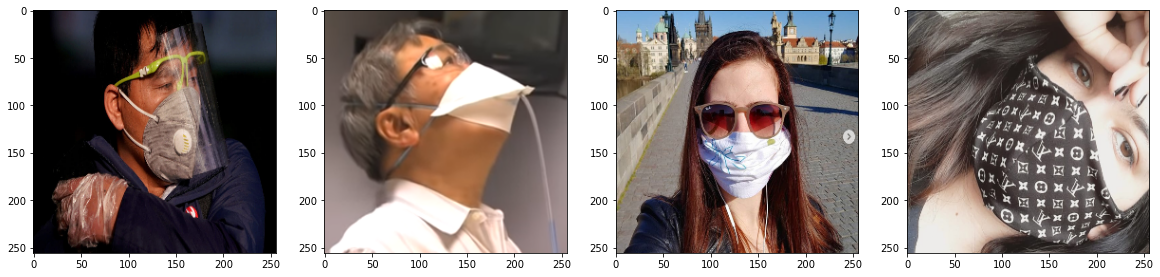

In [3]:
# Dimensions that will be used to rescale the data before using it in the model
width = 256
height = 256
dim = (width, height)

# Files within the directory
files = []
for dirname, _, filenames in os.walk('./Data/Mask'):
    for filename in filenames:
        a = os.path.join(dirname, filename)
        files.append(a)

figure, axes = plt.subplots(ncols=4, figsize=(20,20)) # prepare the plot

example = []
i=0
for sample in range(0,4): # Take the first 4 photos
    img = plt.imread(files[sample])
    img = cv2.resize(img, dim)
    axes[i].imshow(img)
    i = i + 1

plt.show()

### Without mask

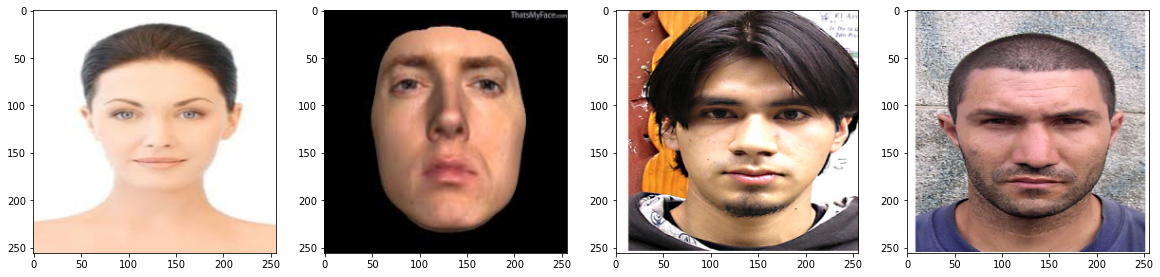

In [4]:
# Dimensions that will be used to rescale the data before using it in the model
width = 256
height = 256
dim = (width, height)

# Files within the directory
files = []
for dirname, _, filenames in os.walk('./Data/No_Mask'):
    for filename in filenames:
        a = os.path.join(dirname, filename)
        files.append(a)

figure, axes = plt.subplots(ncols=4, figsize=(20,20)) # prepare the plot

example = []
i=0
for sample in range(0,4): # Take the first 4 photos
    img = plt.imread(files[sample])
    img = cv2.resize(img, dim)
    axes[i].imshow(img)
    i = i + 1

plt.show()

## Load and prepare the data for the model

In [5]:
# Objects that will contain the pictures and labels
mask_labels = []
mask = []
nomask_labels = []
nomask = []

# Dimensions of the data
width = 256
height = 256
dim = (width, height)

# Data of people wearing a mask

## Get all the files in the directory
files = []
for dirname, _, filenames in os.walk('./Data/Mask'):
    for filename in filenames:
        a = os.path.join(dirname, filename)
        files.append(a)
## Load each file, resize it to the desired dimensions and append it to the corresponding object
for sample in range(0,len(files)):
    img = plt.imread(files[sample])
    img = cv2.resize(img, dim)
    assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
    mask.append(img)
    mask_labels.append([1,0])

    

# Data of people not wearing a mask

## Get all the files in the directory
files = []
for dirname, _, filenames in os.walk('./Data/No_Mask'):
    for filename in filenames:
        a = os.path.join(dirname, filename)
        files.append(a)

## Load each file, resize it to the desired dimensions and append it to the corresponding object
for sample in range(0,len(files)):
    img = plt.imread(files[sample])
    img = cv2.resize(img, dim)
    assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
    nomask.append(img)
    nomask_labels.append([0,1])
    
# Convert all the objects to numpy arrays
mask_labels = np.array(mask_labels)
mask = np.array(mask)
nomask_labels = np.array(nomask_labels)
nomask = np.array(nomask)

#### We will split the data in 80% for train and 20% for validation

In [6]:
# define the dimensions of the data
n_mask = mask.shape[0]
n_nomask = nomask.shape[0]
n_train_mask = n_mask*80//100
n_train_nomask = n_nomask*80//100
n_train = n_train_mask + n_train_nomask

# Split and concatenate the data for training
x_train = np.concatenate([mask[:n_train_mask], nomask[:n_train_nomask]])
y_train = np.concatenate([mask_labels[:n_train_mask], nomask_labels[:n_train_nomask]])

# Split and concatenate the data for validation
x_valid = np.concatenate([mask[n_train_mask:], nomask[n_train_nomask:]])
y_valid = np.concatenate([mask_labels[n_train_mask:], nomask_labels[n_train_nomask:]])

## Load and prepare the model

In [7]:
# Define where the model is and where it will be saved.
inc_path = 'inception/tensorflow_inception_graph.pb'
inc_path2 = 'inception/saved_tf2'
inc_path2_hbn = 'inception/saved_tf2_hbn'

!rm -rf {inc_path2}
!rm -rf {inc_path2_hbn}

# Load and prepare the model using the predefined function
gd_full = convert_model(inc_path, inc_path2, ['input:0', 'output:0'], use_GPU=False)  # original model output
gd_hbn = convert_model(inc_path, inc_path2_hbn, ['input:0', 'head0_bottleneck/reshape:0'], use_GPU=False)  # head0_bottleneck as model output, for our problem

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: inception/saved_tf2/saved_model.pb
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: inception/saved_tf2_hbn/saved_model.pb


In [8]:
# Create the model
model = tf.keras.models.Sequential([
                                    InceptionCut(-1),
                                    tf.keras.layers.Dense(512, activation='sigmoid'),
                                    tf.keras.layers.Dense(2, activation='softmax')
                                    ])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005,) ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None,256,256,3))
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_cut (InceptionCut) (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 1,050,114
Trainable params: 1,050,114
Non-trainable params: 0
_________________________________________________________________


## Train and validate the model

In [9]:
# Define where the iterations will be saved and the number of iterations and batch size
save_path = 'output/text_{epoch}.ckpt'
batch_size=20
n_itr_per_epoch = len(x_train) // batch_size
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                   save_weights_only=True,
                                                   save_freq=5 * n_itr_per_epoch)
# Train the model
hist = model.fit(x_train, y_train,
                 epochs=15, batch_size=batch_size, 
                 validation_data=(x_valid, y_valid),
                 callbacks=[save_callback])

Epoch 1/15
41/41 [==============================] - 62s 2s/step - loss: 0.2440 - accuracy: 0.8812 - val_loss: 0.0931 - val_accuracy: 0.9752
Epoch 2/15
41/41 [==============================] - 63s 2s/step - loss: 0.0285 - accuracy: 0.9942 - val_loss: 0.0853 - val_accuracy: 0.9752
Epoch 3/15
41/41 [==============================] - 64s 2s/step - loss: 0.0139 - accuracy: 0.9989 - val_loss: 0.0705 - val_accuracy: 0.9802
Epoch 4/15
41/41 [==============================] - 69s 2s/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.0707 - val_accuracy: 0.9802
Epoch 5/15
41/41 [==============================] - 66s 2s/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0714 - val_accuracy: 0.9802
Epoch 6/15
41/41 [==============================] - 67s 2s/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.0723 - val_accuracy: 0.9802
Epoch 7/15
41/41 [==============================] - 67s 2s/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 0.0753 - val_accuracy: 0.9802
Epoch 8/15
41/41 [==

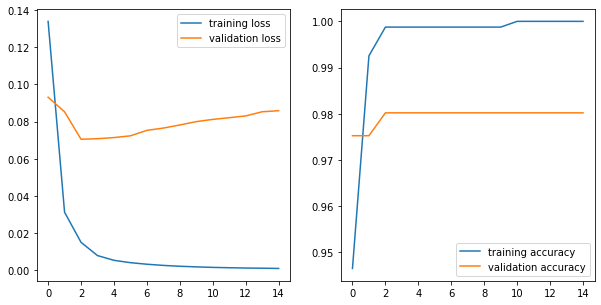

In [10]:
# Plot your model results
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [11]:
# save the trained model
tf.saved_model.save(model, "inference_model/")

# load it in a new object
mod = tf.saved_model.load('inference_model')
func = mod.signatures["serving_default"]
output_name = model.output_names[0]

# Define the inference for the model using the above function
inf = Inferer('inference_model', output_name)

INFO:tensorflow:Assets written to: inference_model/assets


## Face recognition using Dlib convolutional neural network: Example

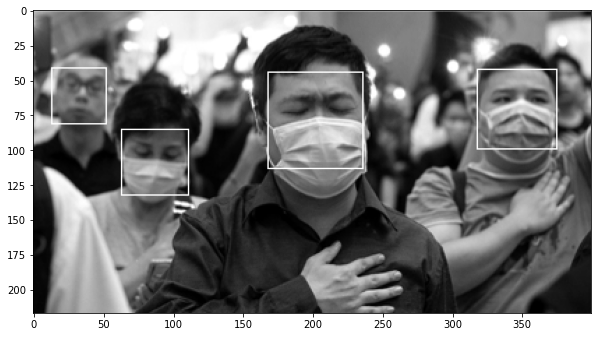

In [12]:
# Load the picture
gray = cv2.imread('./Data_Face_Recog/imagesjpg/maksssksksss254.jpg', 0)
# Inference using the pretrained model
dnnFaceDetector = dlib.cnn_face_detection_model_v1('./Data_Face_Recog/mmod_human_face_detector.dat')
# Get the coordinates of the faces
rects = dnnFaceDetector(gray, 1)
# Draw the rectangles around each detected face
for (i, rect) in enumerate(rects):
    x1 = rect.rect.left()
    y1 = rect.rect.top()
    x2 = rect.rect.right()
    y2 = rect.rect.bottom()
    cv2.rectangle(gray, (x1, y1), (x2, y2), (255, 255, 255), 1)

# Plot the results
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='gray')
plt.show()

## Detect whether people is wearing or not a mask in a photo with various persons

For this final problem, we will first use the Dlib CNN to detect faces on a photo. We then crop each face and infere from the trained inception model whether the cropped face has a mask, and use the outcome to define the color of the rectangle that will be drawn around the face in the final outcome.

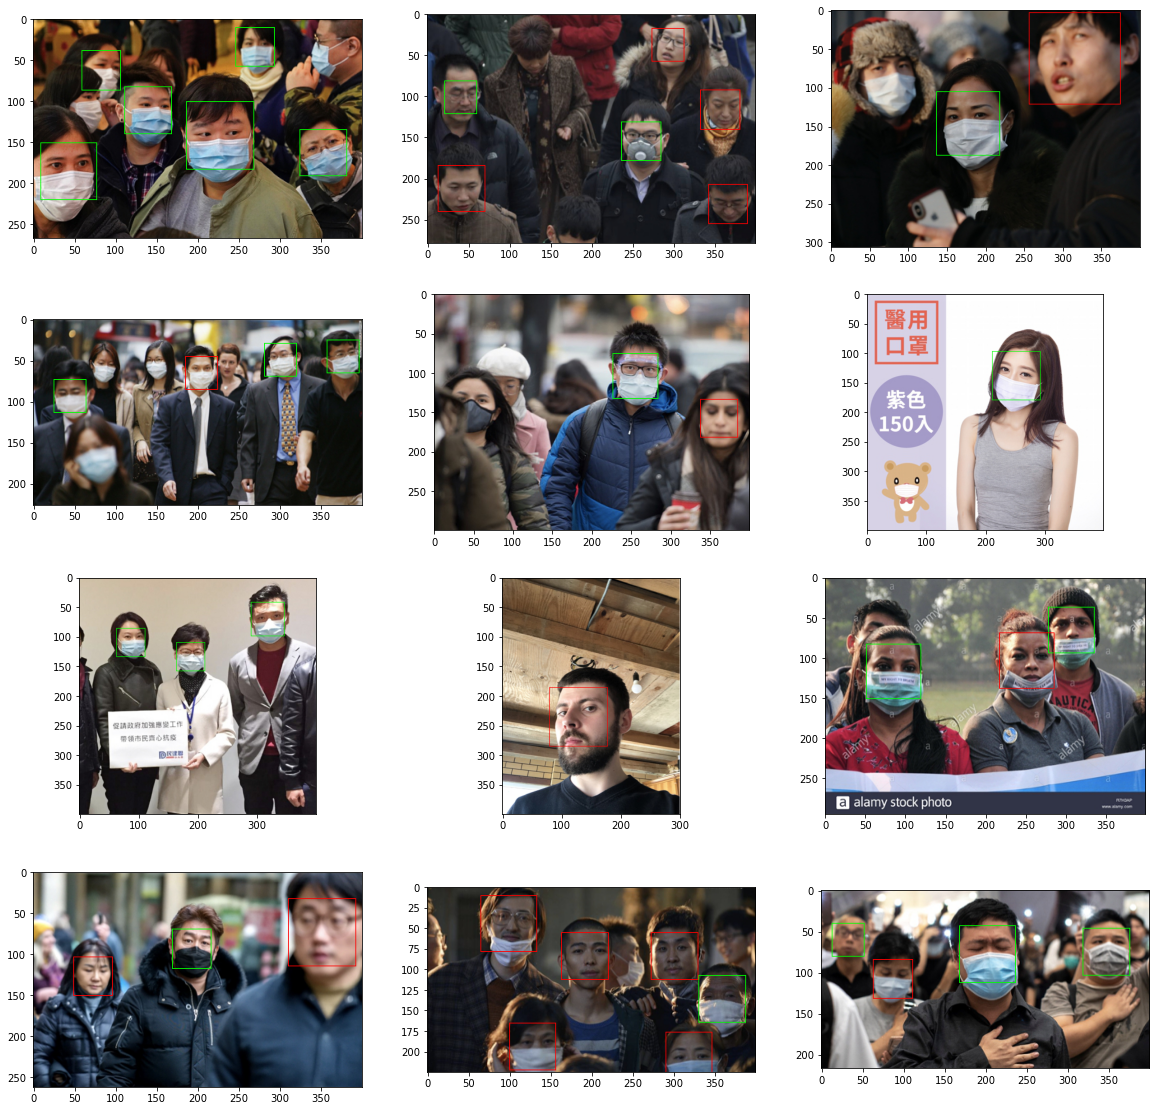

In [13]:
mask_label = {'Mask':(0,255,0),'No Mask':(255,0,0)}

width = 256
height = 256
dim = (width, height)

files = []
for dirname, _, filenames in os.walk('./Data_Face_Recog/imagesjpg'):
    for filename in filenames:
        a = os.path.join(dirname, filename)
        files.append(a)



figure, axes = plt.subplots(nrows = 4, ncols=3, figsize=(20,20)) # prepare the plot
sample = 1

for row in range(0,4):
    for col in range(0,3):
        new_img = plt.imread(files[sample])
        gray = cv2.imread(files[sample])
        dnnFaceDetector = dlib.cnn_face_detection_model_v1('./Data_Face_Recog/mmod_human_face_detector.dat')
        rects = dnnFaceDetector(gray, 1)
        for (i, rect) in enumerate(rects):
            x1 = rect.rect.left()
            y1 = rect.rect.top()
            x2 = rect.rect.right()
            y2 = rect.rect.bottom()
            crop = new_img[y1:y2,x1:x2]
            crop = cv2.resize(crop,dim)
            img = []
            img.append(crop)
            img = np.array(img)
            images_all = np.concatenate([mask[:1],  img])
            mask_result = inf.infere(images_all, prob=True)
            cv2.rectangle(new_img,(x1, y1), (x2, y2),mask_label[mask_result[0][1]],1)
        axes[row,col].imshow(new_img)
        sample = sample + 1
